In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as sopt

def Laplacian(A):
    L = np.zeros(A.shape)
    n = len(A)
    for i in range(n):
        for j in range(n):
            if i==j:
                L[i,j] = np.sum(A[:,j])
            else:
                L[i,j] = -A[i,j]
    return L

def advance_flatten(M):
    indices = np.array(list(np.ndindex(M.shape)))
    df = pd.DataFrame({'val': M.flatten(), 'd0': indices[:, 0], 'd1': indices[:, 1]})
    return df


class EpidemicModel():
    def __init__(self, Theta, B, lambdas, omegas, I, O, D, Y, Z, I_max):
        self.Theta = Theta
        self.B =  B

        lam_f, omg_f = advance_flatten(lambdas), advance_flatten(omegas) 
        self.lam_f = lam_f[(lam_f['val'] > 0) & (lam_f['d1'].isin(D))]
        self.omg_f = omg_f[omg_f['val'] > 0]
        self.c = np.concatenate((self.lam_f['val'].values, self.omg_f['val'].values))

        self.n = len(Theta)
        self.I_max = I_max

        self.I = set(I)
        self.O = set(O)
        self.Y = [set(y) for y in Y]
        self.Z = [set(z) for z in Z]

        self.Theta_L = -Laplacian(Theta)
        self.B_L = self.build_B(B)
        

    def simulate(self, numsteps, dt, x0, control=False):
        x = x0
        xs = [x]
        if not control:
            U_L, V_L = np.zeros(self.Theta_L.shape), np.zeros(self.B_L.shape) 
            for _ in range(numsteps):
                x = x + dt*self.x_dot(x, self.Theta_L, self.B_L, U_L, V_L)
                xs.append(x)
            return xs, None
        
        else:
            controls = []
            for _ in range(numsteps):
                U_L, V_L, control_vec = self.solve_UV(x)
                controls.append(control_vec)
                x = x + dt*self.x_dot(x, self.Theta_L, self.B_L, U_L, V_L)
                xs.append(x)
            return xs, controls

    def x_dot(self, x, Theta, B, U_l, V_l):
        x_d = ((Theta + U_l) + np.kron(x.T,np.eye(len(x)))@(B-V_l))@x
        return x_d
    
    def build_B(self, B_A):
        B = np.zeros((self.n**2,self.n))

        for i, (Y_i, Z_i) in enumerate(zip(self.Y, self.Z)):
            if Y_i:
                for y in Y_i:
                    j, k = y
                    B[self.n*k+i, j] = B_A[j,k]
            
            if Z_i:
                for z in Z_i:
                    j, k = z
                    B[self.n*k+i, j] = -B_A[j,k]
        return B

    def h(self, x):
        inds = [i for i in self.I]
        return self.I_max - np.sum(x[inds])

    def alpha(self,x):
        return x**2

    def d(self, x):
        inds = [i for i in self.O]
        d = (self.Theta_L  + np.kron(x.T,np.eye(len(x)))@self.B_L)@x
        return np.sum(d[inds])

    def solve_UV(self, x):
        # Assemble upper bounds for LP solver
        a_l = x[self.lam_f['d1'].values]
        a_o = np.array([x[i]*x[j] for _, i, j in self.omg_f.itertuples(index=False)])

        # Find solution us LP
        A = -np.atleast_2d(np.concatenate((a_l,a_o)))
        b = self.d(x) + self.alpha(self.h(x))
        
        sol = sopt.linprog(self.c,A,b)
        sol_vals = sol.x 
        
        # Reconstruct weights
        U, V = np.zeros((self.n,self.n)), np.zeros((self.n,self.n))
        for k, tup in enumerate(self.lam_f.itertuples(index=False)):
            _, i, j = tup
            U[i,j] = sol_vals[k]

        for k, tup in enumerate(self.omg_f.itertuples(index=False)):
            _, i, j = tup
            V[i,j] = sol_vals[len(self.lam_f)+k]
        
        # Return controller in proper format
        return  -Laplacian(U), self.build_B(V), sol_vals

In [207]:
############# SIQRS ##############
# beta,eta,sigma,gamma,delta = 1,.1,.1,.1,.5

# Theta_A = np.array([[0, 0,      0,   delta],
#                     [0, 0,      0,     0],
#                     [0, eta,    0,     0],
#                     [0, gamma, sigma,  0]])

# B_A = np.array([[0,     0,  0,  0],
#                 [beta,  0,  0,  0],
#                 [0,     0,  0,  0],
#                 [0,     0,  0,  0]])


# O_cal, I_cal, D_cal, I_max = [0,2,3], [1], [1], 0.1

# Y_cal = [[], [(1,0)], [], []]
# Z_cal = [[(1,0)], [], [], []]

# x0 = np.array([.99,0.01,0,0])

# labels = ['S','I','Q','R']

############# SEIQRS ##############

beta,sigma1,eta,sigma2,gamma,delta = 1, .5, .2, .1, .1, .5

Theta_A = np.array([[0, 0,      0,     0,  delta],
                    [0, 0,      0,     0,      0],
                    [0, sigma1, 0,     0,      0],
                    [0, 0,     eta,    0,      0],
                    [0, 0,     gamma, sigma2,  0]])

B_A = np.array([[0,     0,  0,  0, 0],
                [0,     0,  0,  0, 0],
                [beta,  0,  0,  0, 0],
                [0,     0,  0,  0, 0],
                [0,     0,  0,  0, 0]])


O_cal, I_cal, D_cal, I_max = [0,3,4], [1,2], [2], 0.1

Y_cal = [[], [(2,0)], [], [], []]
Z_cal = [[(2,0)], [], [], [], []]

x0 = np.array([.99, 0, 0.01, 0, 0])



numsteps = 1000
dt = .1

lambdas = ((Theta_A > 0).astype(float))*1.1
lambdas[3,2] = 1
omegas = (B_A > 0).astype(float)

params = [[lambdas, omegas, False], [lambdas, omegas, True], [lambdas, .8*omegas, True]]
group_label = ['No Control', r'$\Lambda_1, \Omega_1$', r'$\Lambda_1, \Omega_2$']
xs_list, uv_list = [], []
for p in params:
    ls, os, con = p

    model = EpidemicModel(Theta_A, B_A, ls, os, I_cal, O_cal, D_cal, Y_cal, Z_cal, I_max)

    xs, uv = model.simulate(numsteps, dt, x0, con)

    xs_list.append(xs)
    uv_list.append(uv)

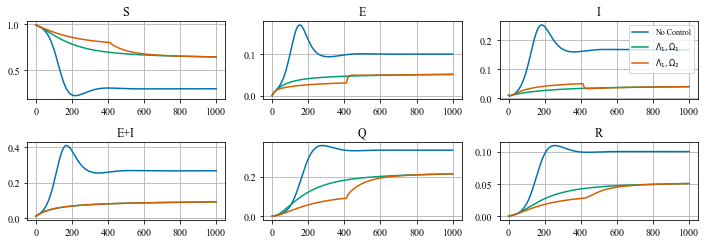

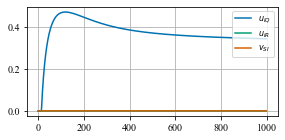

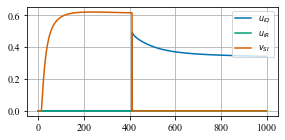

In [208]:
# plot results
import matplotlib.style as style

plt.rcParams["font.family"] = "Times New Roman"
style.use('seaborn-colorblind')

labels = ['S','E','I','E+I','Q','R']
sum_inds = [(0),(1),(2),(1,2), (3), (4)]

plt.figure(figsize=(10,3.5))
for i, ind in enumerate(sum_inds):
    plt.subplot(2,3,i+1)
    for j, xs_a in enumerate(xs_list):
        xs_arr = np.array(xs_a)
        if i == 3:
            plt.plot(np.sum(xs_arr[:,ind], axis=1), label=group_label[j])
        else:
            plt.plot(xs_arr[:,ind], label=group_label[j])
    # plt.xlabel('k')
    plt.grid()
    if i == 2:
        plt.legend(loc='upper right',prop={'size':8})
    plt.title(labels[i])
plt.tight_layout()
plt.savefig('figures/SEIQRS_combineEI_cbf.png', dpi=300, facecolor='white', transparent=False)

for i, uv in enumerate(uv_list):
    if uv:
        uv_arr = np.array(uv)
        labels = ['$u_{IQ}$','$u_{IR}$','$v_{SI}$']
        plt.figure(figsize=(4.5,2))
        plt.plot(uv_arr)
        # plt.title(group_label[i])
        plt.grid()
        plt.legend(labels, loc='upper right',prop={'size':8})

        plt.savefig('figures/SIQRS_control_'+str(i)+'.png', dpi=300, facecolor='white', transparent=False)

plt.show()